# Biosignal generator tutorial

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/CiC_work/framework_for_synthetic_biosignals')

In [3]:
!pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 5.1 MB/s eta 0:00:00


In [4]:
import os
os.getcwd()
new_direct = "/content/drive/MyDrive/Colab_Notebooks/CiC_work/framework_for_synthetic_biosignals"
os.chdir(new_direct)

In [5]:
# %matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import ecg_generator as eg
import ppg_generator as pg
import noise_generator as ng
import beat_interval_generator as big

## Signal generation

### ECG

To generate ECG signal, you must initialize an object of class ECGGenerator(SignalGenerator) that inherits the class SignalGenerator that generates the waves of each RR interval. The ECGGenerator class contains all the wave parameters (for five waves: p, q, r, s and t), and their ranges, the information about the beat intervals and added noise.

The function generating biosignal returns:

1. the signal as an np.array,

2. locations of R peaks and P and T waves as a np.array of the same length as the signal, where value 0.2 is for P waves, 0.4 for T waves, 0.6 for R peaks and 0 elsewhere,

3. noise labels as a list of tuples:
    
    a) the first tuple is of the form (noise type as string, noise amplitude as np.array)

    b) if multiple noises is added via noise_list, these tuples are also of the previous form, where the np.array is of the length of the corresponding part of the signal
    
    c) the last tuple is of the form (artefact type as string, artefact amplitude as np.array), where the np.array is of the length of the whole signal

4. beat intervals.



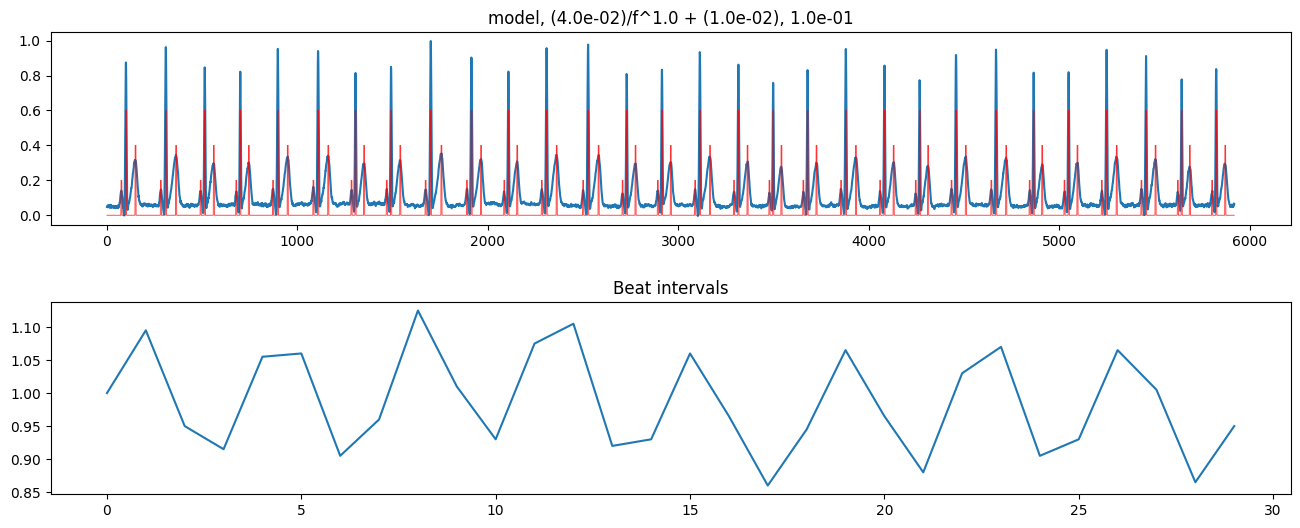

In [6]:
# Generating ECG with default values
ecg = eg.ECGGenerator()
signal, peaks, labels, beats = ecg.generate()

fig, ax = plt.subplots(2,1,figsize=(16,6))
plt.subplots_adjust(hspace=0.4)
ax[0].plot(signal)
ax[0].plot(peaks, alpha=0.8, color='red', linewidth=0.6)

# Set noise label as the title
ax[0].set_title(labels[0][0])
ax[1].plot(beats)
ax[1].set_title('Beat intervals')

plt.show()

Pure signal can be generated either by setting noise_type.amplitude = 0 and artifact_bool = False or by setting the noise_generator to None. To determine how the beat intervals are generated, one can set these values by ecg.beat_interval_generator.parameter = ...
The parameters and their ranges can be found in the beat_interval_generator module.

Also the model can use an existing array of beat intervals as shown in the following code cell.

The signal length is determined by ecg.number_of_beats, which effects the number of beat intervals that are generated. If noise is added (the noise_generator is not None) and beat intervals are generated (beat_intervals is None), the duration of the signal is determined by ecg.noise_generator.noise_type.duration. In cases where these two (ecg.number_of_beats and noise_type.duration) collide, the signal length correspondes to the shorter of the two.

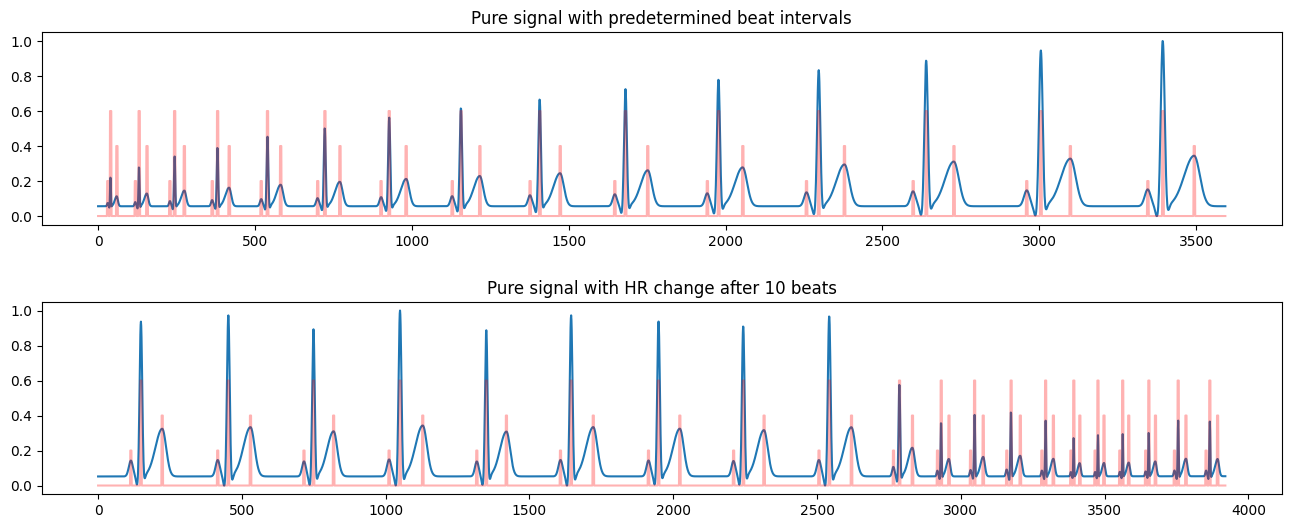

In [7]:
# Using list of beat intervals
ecg.beat_interval_generator.beat_intervals = np.linspace(0.4, 2, 15)
# Beat intervals can also be loaded with function data_from_records in utils.py

# No noise to be added to the signal
ecg.noise_generator.noise_type.amplitude = 0
ecg.noise_generator.artifact_bool = False

signal, peaks, labels, beats = ecg.generate()

fig, ax = plt.subplots(2,1,figsize=(16,6))
plt.subplots_adjust(hspace=0.4)
ax[0].plot(signal)
ax[0].plot(peaks, alpha=0.3, color='r')
ax[0].set_title('Pure signal with predetermined beat intervals')

# Clearing the predetermined beat intervals
ecg.beat_interval_generator.beat_intervals = None
# How many beat intervals are generated
ecg.number_of_beats = 20
# Setting average beat interval length
ecg.beat_interval_generator.mu = 1.5
# Enabling change in HR
ecg.beat_interval_generator.step = True
# Setting average beat interval length after change
ecg.beat_interval_generator.mu_new = 0.5
# Where the change happens in relation to beat intervals
ecg.beat_interval_generator.step_i = 0.5

signal, peaks, labels, beats = ecg.generate()

ax[1].plot(signal)
ax[1].plot(peaks, alpha=0.3, color='r')
ax[1].set_title('Pure signal with HR change after '+str(int(ecg.beat_interval_generator.step_i*ecg.beat_interval_generator.n))+' beats')

plt.show()

The waveform can be adjusted by changing the wave parameters (amplitude, width, distance and symmetry) in the generator class.

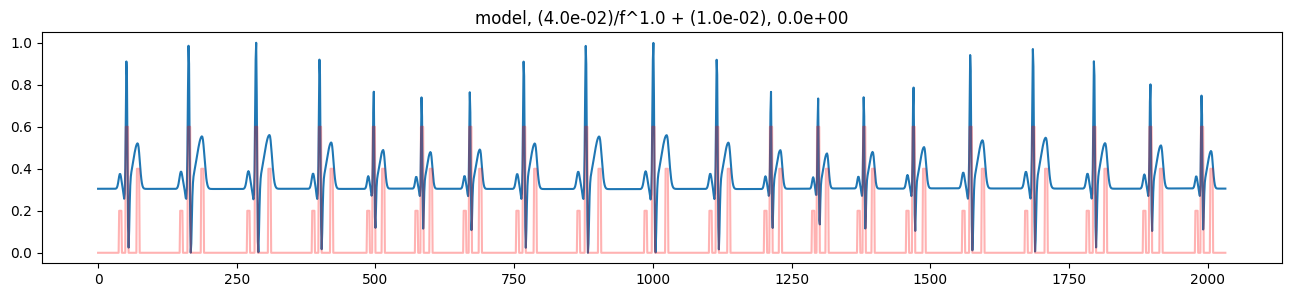

In [8]:
# Randomize the beat intervals
ecg.beat_interval_generator.randomize()

# Changing the witdth of R wave
ecg.ecg_width.r = 0.08
# Increasing the amplitude of S wave
ecg.ecg_amplitude.s = -0.5
# Making T wave more left skewed
ecg.ecg_symmetry.t = 5
# Distance of T wave in relation to R peak
ecg.ecg_distance.t = 0.2

signal, peaks, labels, beats = ecg.generate()

plt.figure(figsize=(16,3))
plt.plot(signal)
plt.plot(peaks, alpha=0.3, color='r')
plt.title(labels[0][0])

plt.show()


### PPG

PPG is generated exactly the same as ECG, though there are only two waves (systolic and diastolic) in one cardiac cycle. The function generate() returns:
1. signal as np.array
2. locations of peaks as np.array, where value 0.5 denotes the systolic peak and value 0.25 denotes the diastolic trough.
3. noise labels as in ecg
4. beat intervals

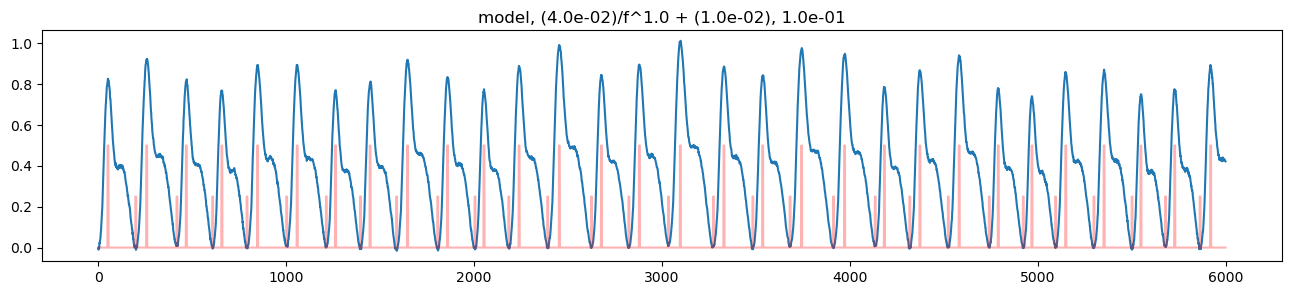

In [ ]:
# Generating PPG with default values
ppg = pg.PPGGenerator()
signal, peaks, labels, beats = ppg.generate()

plt.figure(figsize = (16, 3))
plt.plot(signal)
plt.plot(peaks, alpha=0.3, color='r')
plt.title(labels[0][0])

plt.show()

## Noise generator

The noise is generated in an object of class NoiseGenerator found in module noise_generator. There are four types of added noise: model, point frequency, randomized real measurements and adding a real artefact. In this example pure synthetic ECG is used as a signal, to which the noise is added. The noise module is used exactly the same for PPG.

In [9]:
# Create a default ECGGenerator object to ensure that ecg exists,
# ecg.NoiseGenerator is not None and noise_list defaults to an empty list
ecg = eg.ECGGenerator()

### Model noise

Model PSD = c/f^alpha + wn, where c is the coefficient for 1/f noise and wn is white noise. The more specific explanation of the model noise can be found in the publication. In the following code cell the usage of the NoiseGenerator in the ECGGenerator class is demonstrated.

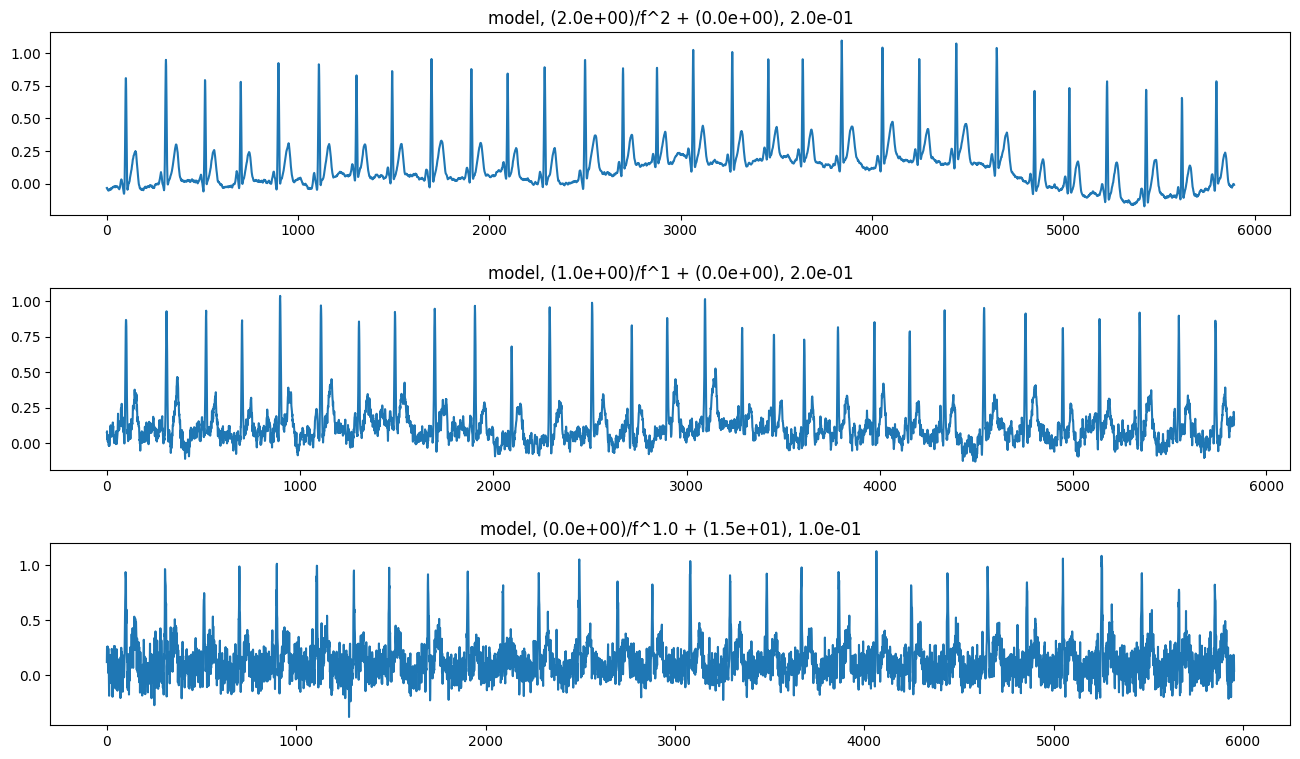

In [10]:
# The noise type is model
ecg.noise_generator.noise_type.name = 'model'
# Set value for parameter alpha
ecg.noise_generator.noise_type.alpha = 2   #Brown noise
# Set power of 1/f^alpha noise
ecg.noise_generator.noise_type.c = 2
# Set power of white noise
ecg.noise_generator.noise_type.wn = 0
# Set the overall amplitude/power of the model noise
ecg.noise_generator.noise_type.amplitude = 0.2

noisy_signal1, peaks1, labels1, beats1 = ecg.generate()

ecg.noise_generator.noise_type.alpha = 1   #pink noise
ecg.noise_generator.noise_type.c = 1
noisy_signal2, peaks2, labels2, beats2 = ecg.generate()

# Or with noise_type, only white noise
ecg.noise_generator.noise_type = ng.NoiseType(amplitude=0.1, c=0, wn=15)

noisy_signal3, peaks3, labels3, beats3 = ecg.generate()

fig, ax = plt.subplots(3, 1, figsize=(16, 9))
plt.subplots_adjust(hspace=0.4)

ax[0].plot(noisy_signal1)
ax[1].plot(noisy_signal2)
ax[2].plot(noisy_signal3)
ax[0].set_title(labels1[0][0])
ax[1].set_title(labels2[0][0])
ax[2].set_title(labels3[0][0])
plt.show()

### Adding point frequency

If user wants to add point frequency, the boolean value of point_bool in noise_type must be set as True. The values for point frequency are the frequency as point_freq and the power of the selected frequency as point_value. The parameter point_freq is a value in (0, 1] representing the selected frequency as point_freq*Nyquist frequency.

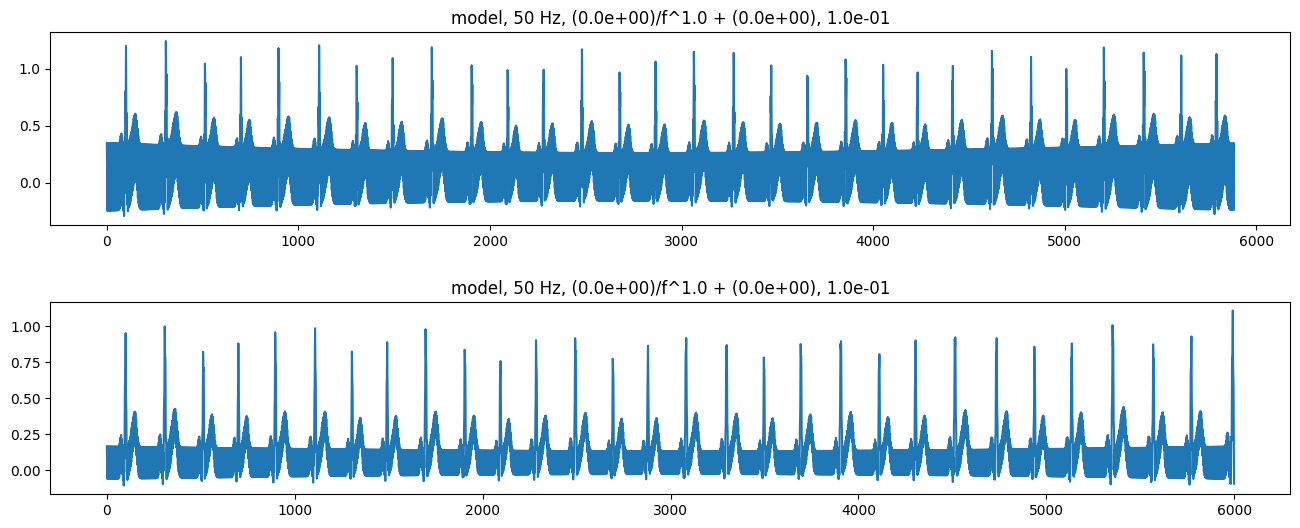

In [11]:
# Let's set all other noise as 0, point_bool to True and determine the added frequency and its value
ecg.noise_generator.noise_type = ng.NoiseType(name='model', c=0, wn=0, duration=30, amplitude=0.1,
                                              point_bool=True, point_freq=0.5, point_value=60)
                                            # point_freq = added_frequency/(sample_frequency/2)

noisy_signal4, peaks4, labels4, beats4 = ecg.generate()

# These parameters can also be adjusted in the following way
ecg.noise_generator.noise_type.point_freq = 0.5
ecg.noise_generator.noise_type.point_value = 5
noisy_signal5, peaks5, labels5, beats5 = ecg.generate()


fig, ax = plt.subplots(2,1,figsize=(16, 6))
plt.subplots_adjust(hspace=0.4)
ax[0].plot(noisy_signal4)
ax[1].plot(noisy_signal5)
ax[0].set_title(labels4[0][0])
ax[1].set_title(labels5[0][0])

plt.show()

Text(0.5, 1.0, 'model, (0.0e+00)/f^1.0 + (2.5e+00), 1.0e-01')

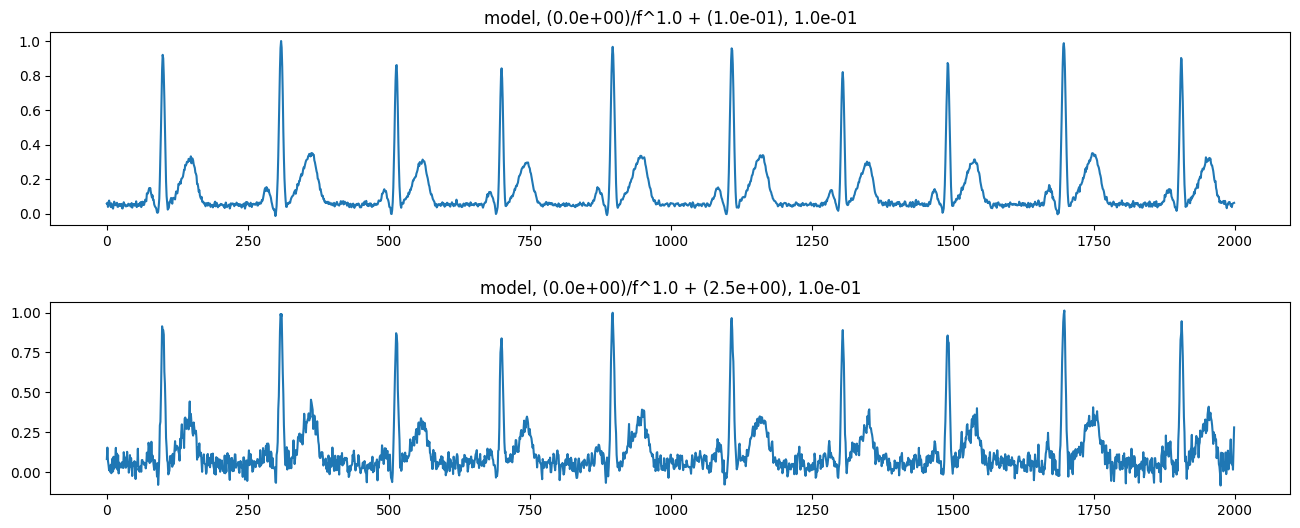

In [28]:
# Let's set all other noise as 0, point_bool to True and determine the added frequency and its value
ecg.noise_generator.noise_type = ng.NoiseType(name='model', c=0, wn=0.1, duration=10, amplitude=0.1,
                                              point_bool=False, point_freq=0.1, point_value=2)
                                            # point_freq = added_frequency/(sample_frequency/2)

noisy_signal4, peaks4, labels4, beats4 = ecg.generate()

ecg.noise_generator.noise_type = ng.NoiseType(name='model', c=0, wn=2.5, duration=10, amplitude=0.1,
                                              point_bool=False, point_freq=0.25, point_value=2)
                                            # point_freq = added_frequency/(sample_frequency/2)

noisy_signal5, peaks5, labels5, beats5 = ecg.generate()


fig, ax = plt.subplots(2,1,figsize=(16, 6))
plt.subplots_adjust(hspace=0.4)
ax[0].plot(noisy_signal4)
ax[1].plot(noisy_signal5)
ax[0].set_title(labels4[0][0])
ax[1].set_title(labels5[0][0])

### PSD of real noise

Adding noise from real measured PSDs is done by setting the noise_type.name to correspond to an available noise type that are 'walking', 'hand_movement', 'muscle_artifact' and 'baseline_wander'. These PSDs are transformed into the time domain and standardized. This signal is then multiplied by the attribute amplitude and then added to the synthetic biosignal. In this case the attributes alpha, c and wn attributes are irrelevant.

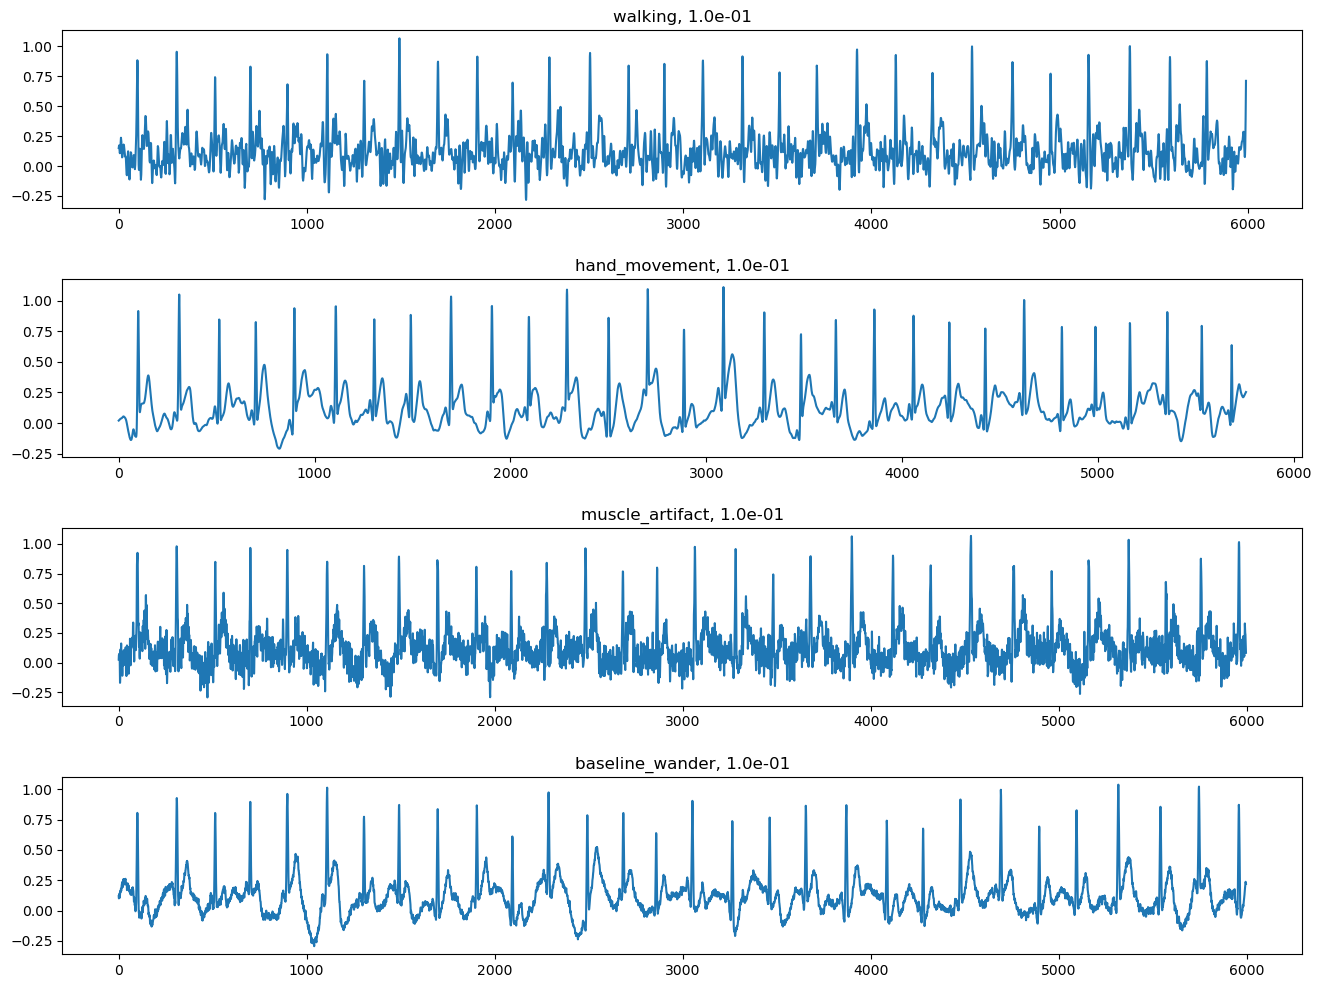

In [ ]:
ecg.noise_generator.noise_type = ng.NoiseType(name='walking', amplitude=0.1)
noisy_signal7, peaks7, labels7, beats7 = ecg.generate()

ecg.noise_generator.noise_type.name = 'hand_movement'
noisy_signal8, peaks8, labels8, beats8 = ecg.generate()

ecg.noise_generator.noise_type.name = 'muscle_artifact'
noisy_signal9, peaks9, labels9, beats9 = ecg.generate()

ecg.noise_generator.noise_type.name = 'baseline_wander'
noisy_signal10, peaks10, labels10, beats10 = ecg.generate()

fig, ax = plt.subplots(4,1,figsize=(16,12))
plt.subplots_adjust(hspace=0.4)

ax[0].plot(noisy_signal7)
ax[1].plot(noisy_signal8)
ax[2].plot(noisy_signal9)
ax[3].plot(noisy_signal10)

ax[0].set_title(labels7[0][0])
ax[1].set_title(labels8[0][0])
ax[2].set_title(labels9[0][0])
ax[3].set_title(labels10[0][0])

plt.show()

### Real artefact

An artefact is added by setting the artifact_bool to True. The type, length, amplitude and location (start) of the artefact can be determined with corresponding parameters. Parameter artifact_idx determines which part is used from the measured artefact. Unlike all the previously presented noise, artefacts are not randomized, therefore one can add exactly identical artefacts when using the same parameters.

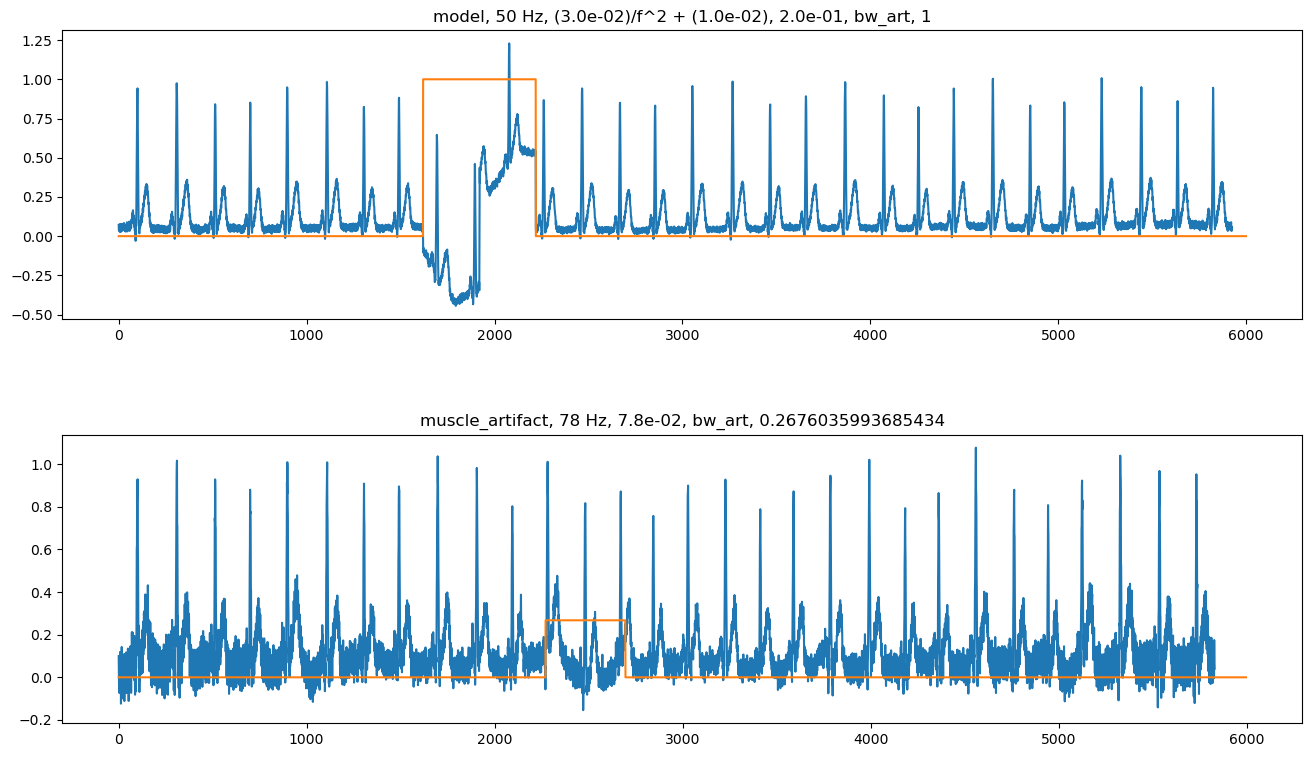

In [ ]:
# Add the artefact
ecg.noise_generator.artifact_bool = True
# Set the amplitude coeffcient of the artefact
ecg.noise_generator.artifact_amp = 1
# Set the location of the artefact
ecg.noise_generator.artifact_start = 0.3
# Set the type of artefact ('bw'= baseline wander, 'ma' = muscle artefact)
ecg.noise_generator.artifact_type = 'bw'

# Add noise
ecg.noise_generator.noise_type = ng.NoiseType(name='model', amplitude=0.2,
                                              alpha=2, c=0.03, wn=0.01,
                                              point_bool=True, point_freq=0.5, point_value=0.5)
noisy_signal1, peaks1, labels1, beats1 = ecg.generate()

# Randomize the noise parameters, but ensure that artefact is added
ecg.noise_generator.artifact_prob = 1
ecg.noise_generator.randomize()
noisy_signal2, peaks2, labels2, beats2 = ecg.generate()

fig, ax = plt.subplots(2, 1, figsize=(16, 9))
plt.subplots_adjust(hspace=0.4)

ax[0].plot(noisy_signal1)
ax[0].plot(labels1[-1][1]) # plot the amplitude coefficient of the artefact
ax[0].set_title(labels1[0][0]+', '+labels1[1][0])

ax[1].plot(noisy_signal2)
ax[1].plot(labels2[-1][1]) # plot the amplitude coefficient of the artefact
ax[1].set_title(labels2[0][0]+', '+labels2[1][0])
plt.show()

### Long-term signals

To generate signal with different types of noises, these NoiseType objects should be added to the ECGGenerator's noise_list as shown in the following code cell. If the noise_list is not empty, the object noise_generator.noise_type does not impact the generated noise.

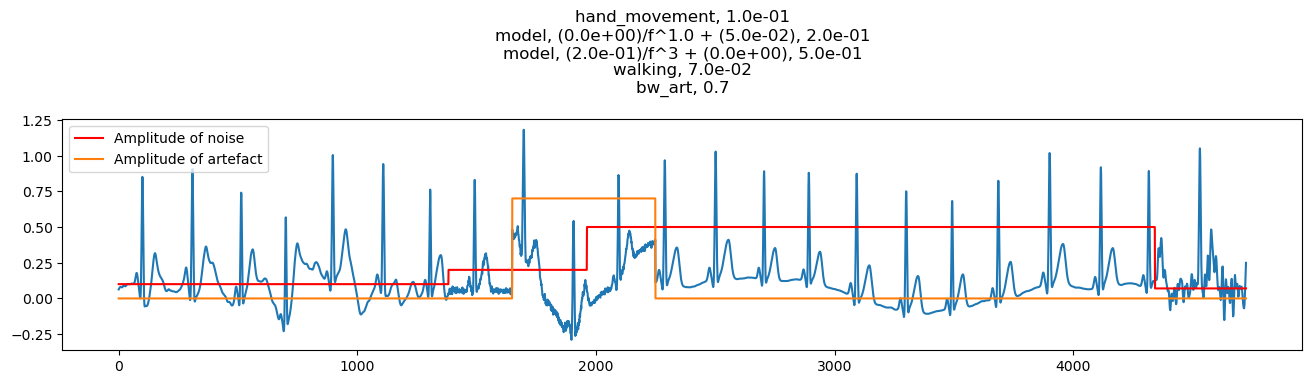

In [ ]:
# Set the noise types to noise_list
ecg.noise_generator.noise_list = [ng.NoiseType('hand_movement', duration=7, amplitude=0.1),
                                  ng.NoiseType('model', amplitude=0.2, c=0, wn=0.05, duration=3),
                                  ng.NoiseType('model', amplitude=0.5, alpha=3, c=0.2, wn=0, duration=12),
                                  ng.NoiseType('walking', amplitude=0.07, duration=2)]

# Adjust the artefact
ecg.noise_generator.artifact_bool = True
ecg.noise_generator.artifact_amp = 0.7
ecg.noise_generator.artifact_length = 3
ecg.noise_generator.artifact_start = 0.4

signal, peaks, labels, beats = ecg.generate()

# Empty the noise list
ecg.noise_generator.noise_list = []

fig, ax = plt.subplots(1, 1, figsize=(16,3))
ax.plot(signal)
noise_amp = np.array([])
for i in labels[:-1]:
    noise_amp = np.append(noise_amp, i[1])
ax.plot(noise_amp, c='r', label='Amplitude of noise')
ax.plot(labels[-1][1], label='Amplitude of artefact')
plt.legend(loc='upper left')

# Print the title as multiple rows
title = ''
for i in labels:
    title = title + i[0] + '\n'
ax.set_title(title)
plt.show()



## Random sets

Random sets of signals are generated by using the function generate_random_set(self, number_of_signals, duration). This function utilizes the randomization functions in each class, thus user can affect the noise of the generated sets by changing the ranges in the NoiseGenerator object, beat intervals by changing the ranges in BeatIntervalGenerator object or the waveform by changing the ranges in the ecg or ppg generator. Let's use PPG for this example.

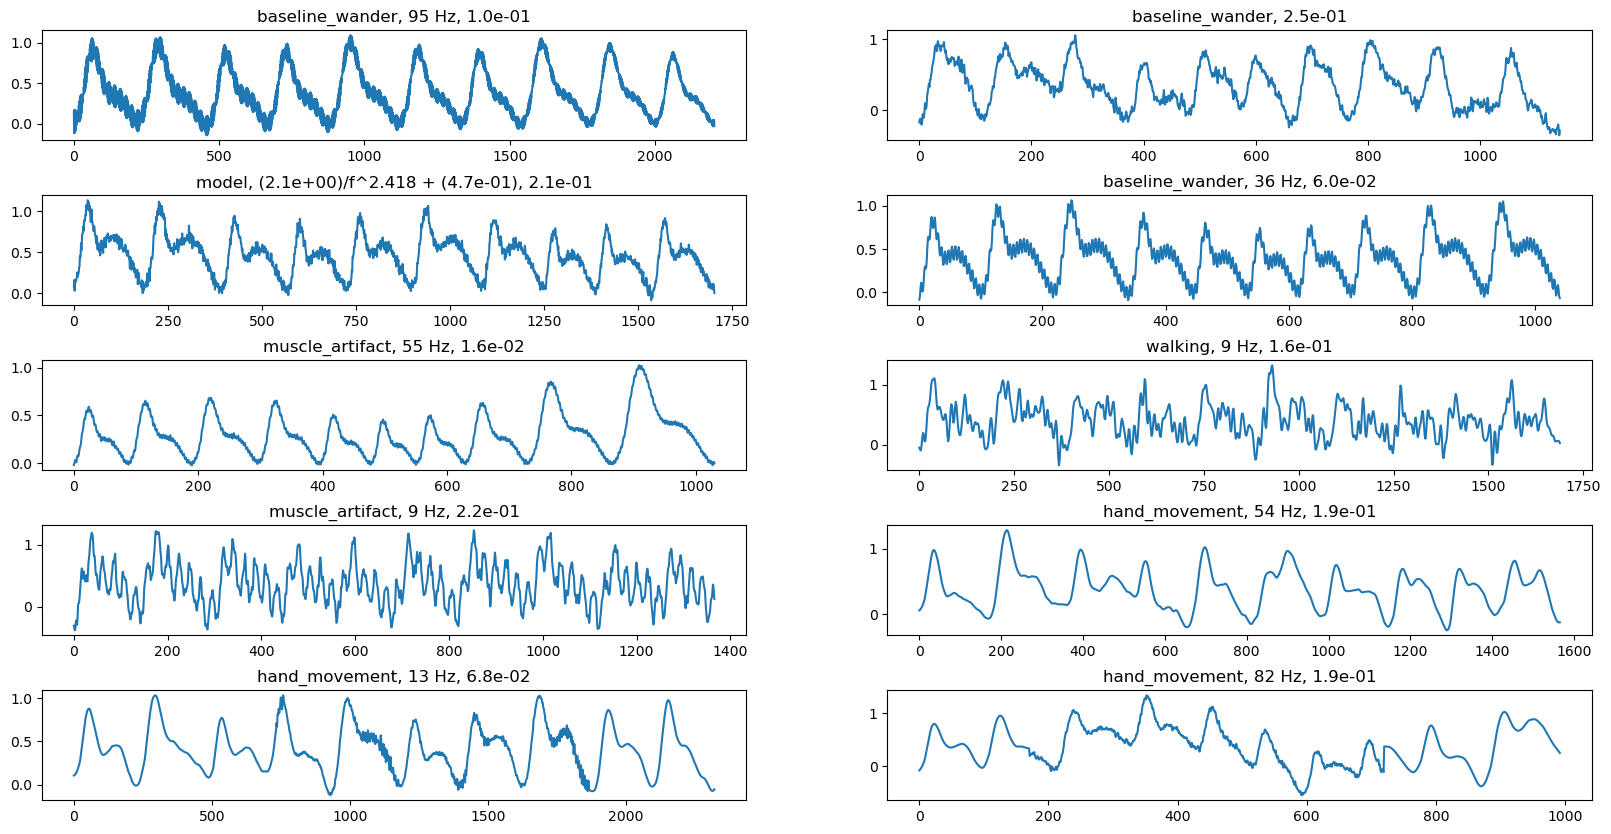

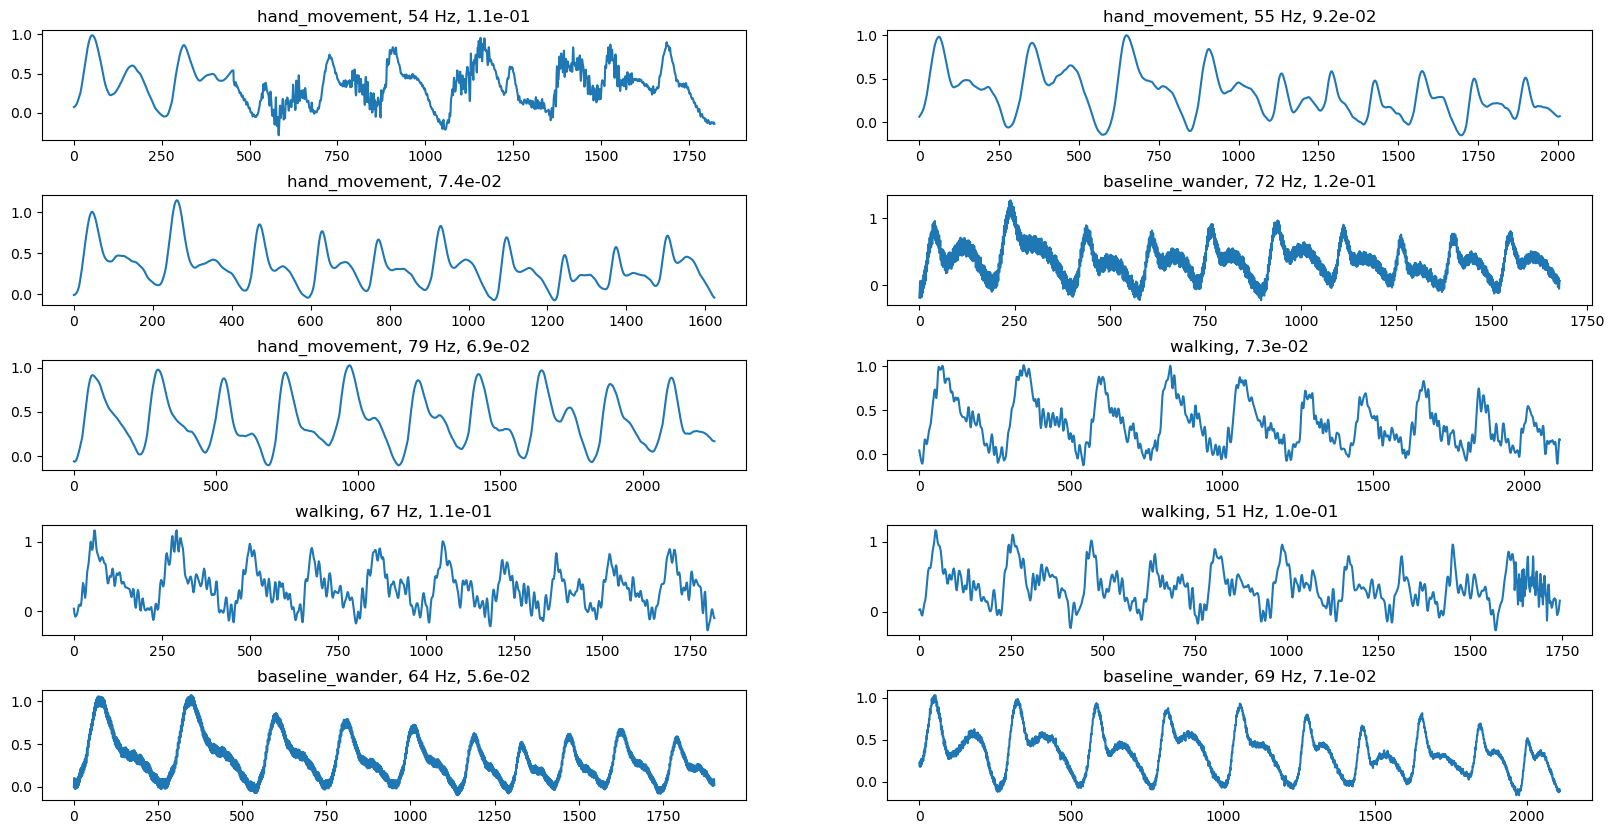

In [ ]:
# Let's create ppg object if not already defined
ppg = pg.PPGGenerator()

n = 10
dur = 10

# Generate random set of PPG signals
signals, peaks, labels, beats = ppg.generate_random_set(number_of_signals=n, duration=dur)

fig, ax = plt.subplots(5, 2, figsize=(20,10))
plt.subplots_adjust(hspace=0.5)
for i in range(5):
    for j in range(2):
        ax[i,j].plot(signals[i+5*j])
        ax[i,j].set_title(labels[i+5*j][0][0])


# Change the randomization properties and generate another set of PPG signals
# Adjust the ranges for noise randomization
ppg.noise_generator.amplitude_rng = [0.05, 0.12]
ppg.noise_generator.point_prob = 0.8
ppg.noise_generator.point_freq_rng = [0.5, 0.8]
ppg.noise_generator.point_value_rng = [1, 5]
ppg.noise_generator.noise_types = [('baseline_wander', 0.2), ('hand_movement', 0.5), ('walking', 0.1), ('model', 0.2)]
ppg.noise_generator.artifact_prob = 0.3
ppg.noise_generator.artifact_amp_rng = [0.8, 1.2]

# Adjust the ranges for beat interval randomization
ppg.beat_interval_generator.mu_rng = [1, 1.8]
ppg.beat_interval_generator.mu_new_rng = [0.4, 0.8]
ppg.beat_interval_generator.step_prob = 0.8
ppg.beat_interval_generator.step_i_rng = [0.1, 0.5]

# Adjust waveform parameter ranges
ppg.ppg_amplitude_high.fst = 0.9
# Lower amplitude limit for both waves
ppg.ppg_amplitude_low = pg.PPGWavePrms(0.7, 0.6)

signals, peaks, labels, beats = ppg.generate_random_set(number_of_signals=n, duration=dur)

fig, ax = plt.subplots(5, 2, figsize=(20,10))
plt.subplots_adjust(hspace=0.5)
for i in range(5):
    for j in range(2):
        ax[i,j].plot(signals[i+5*j])
        ax[i,j].set_title(labels[i+5*j][0][0])

plt.show()

## PPG with pulse transit time (PTT)

Pulse transit time can be modelled with function gen_ppg_with_ppt(beat_intervals, offset, change_offset, peaks_ecg, idx), where parameter
1. offset is the delay (time) of the PPG signal's diastolic trough from the ventricular contraction, assuming the contraction happens in the middle of the beat interval,
2. change_offset is the adjustment to the delay; in the example below, the delay is corrected to align the diastolic troughs and R-peaks,
3. peaks_ecg is an array, where the values are 0.6 in the indeces of R peaks, 0.2 for P waves and 0.4 for T waves, and 0 elsewhere,
4. idx is where the change happens in relation to the signal length.

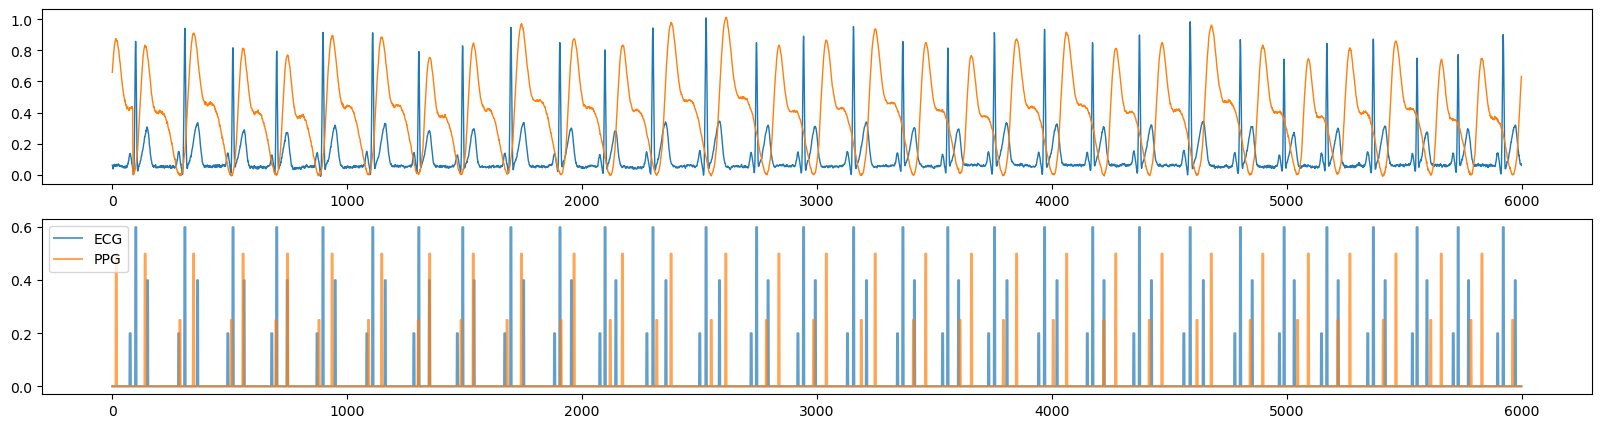

In [ ]:
ppg = pg.PPGGenerator()
ecg = eg.ECGGenerator()

# Generate ECG signal
signal_ecg, peaks_ecg, labels_ecg, beats_ecg = ecg.generate()

# First there is a delay of 0.2 seconds that is increased to 0.5 after the first third of the signal.
signal_ppg, peaks_ppg, labels_ppg, beats_ppg = ppg.gen_ppg_with_ptt(beat_intervals=beats_ecg,
                                                                    offset=0.2, change_offset=0.3,
                                                                    peaks_ecg=peaks_ecg, idx=0.3)

fig, ax = plt.subplots(2, 1, figsize=(20,5))
ax[0].plot(signal_ecg, linewidth=1)
ax[0].plot(signal_ppg, linewidth=1)
ax[1].plot(peaks_ecg, alpha=0.7, label='ECG')
ax[1].plot(peaks_ppg, alpha=0.7, label='PPG')
plt.legend(loc='upper left')

plt.show()